In [10]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from scipy.ndimage.filters import correlate
Epsilon = 1e-7
DPI = 120
RADIUS = 2
THICKNESS = 2
COLOR = [255,0,0]

C:\Users\fadri_zkxoohp\AppData\Local\Temp\ipykernel_2172\184973183.py:5: DeprecationWarning: Please use `correlate` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import correlate


### load image and compute the gradient

In [11]:
# TODO 
input_img = cv2.imread('inputs/I1_rotate.jpg', 0) / 255
dy, dx = np.gradient(input_img)



### Compute structure tensor

In [12]:
# TODO 
# Calculate the gradient in the x and y directions
gradient_x = cv2.Sobel(input_img, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(input_img, cv2.CV_64F, 0, 1, ksize=3)

Ixx = gradient_x * gradient_x
Ixy = gradient_x * gradient_y
Iyy = gradient_y * gradient_y

Ixx = gaussian_filter(Ixx, sigma=1)
Ixy = gaussian_filter(Ixy, sigma=1)
Iyy = gaussian_filter(Iyy, sigma=1)


print(Ixx)

[[9.07113998e-05 1.39582902e-04 1.44615418e-04 ... 1.15229479e-03
  5.48562073e-04 1.32145272e-04]
 [1.01795045e-04 1.63682326e-04 1.91112921e-04 ... 1.10271519e-03
  5.63951918e-04 1.45666070e-04]
 [1.07222035e-04 1.78595502e-04 2.27002367e-04 ... 8.44827359e-04
  4.55324890e-04 1.31581748e-04]
 ...
 [1.63167883e-03 3.25905175e-03 3.84911193e-03 ... 8.50630494e-04
  5.01912793e-04 1.65622057e-04]
 [2.02705286e-03 3.84207895e-03 4.19017436e-03 ... 1.06262104e-03
  6.45318078e-04 2.23865883e-04]
 [2.27849035e-03 3.98532748e-03 3.88454399e-03 ... 1.07822006e-03
  6.72948175e-04 2.49831166e-04]]


### Compute Shi-Thomasi response and Harris response, please compare them in the end

In [13]:
from numpy import linalg as LA
# TODO 
# Constuct the matrix M out of Ixx, Ixy, Iyy
def shitomasi(img, Ixx, Iyy, Ixy):
    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])

    print('M: ' , M.shape)


    sqrt_part = np.sqrt((Ixx - Iyy)**2 + 4 * Ixy**2)

    lambda1 = 0.5 * (Ixx + Iyy + sqrt_part)
    lambda2 = 0.5 * (Ixx + Iyy - sqrt_part)

    # Find the smaller eigenvalue for each pixel
    smaller_eigenvalues = np.minimum(lambda1, lambda2)

    mean_smaller_eigenvalues = np.mean(smaller_eigenvalues)

    #Eigenvalue < 5 * mean
    selected_pixels = np.where(smaller_eigenvalues > 5 * mean_smaller_eigenvalues, smaller_eigenvalues, 0)


    # Apply dilation - this gives the maximum in the 5x5 neighborhood
    dilated = cv2.dilate(selected_pixels, np.ones((5,5)))

    # Non-maximum suppression: wherever the original image is less than the dilated one, suppress it
    non_max_suppression = np.where(selected_pixels < dilated, 0, 1)

    new_image = np.zeros_like(non_max_suppression, dtype=np.uint8)  
    new_image[non_max_suppression > 0] = 255  # set the selected pixels to white

    # # Display the image
    # plt.imshow(new_image, cmap='gray')
    # plt.show()

    return new_image


# response_harris = cv2.cornerHarris(input_img, 2, 3, 0.04)

def response_harris_diy(Ixx, Ixy, Iyy, k=0.03):
    det = Ixx * Iyy - Ixy**2
    trace = Ixx + Iyy
    return det - k * trace**2

response_harris_diy = response_harris_diy(Ixx, Ixy, Iyy)
# set every value below 0.001 to 0 and the rest to 255
# response_harris_diy = np.where(response_harris_diy < 0.001, 0, 1)
response_shitomasi = shitomasi(input_img, Ixx, Iyy, Ixy)


#show the response harris image
# plt.imshow(response_harris_diy, cmap='gray')



M:  (2, 2, 3264, 2448)


### Visualise the response map

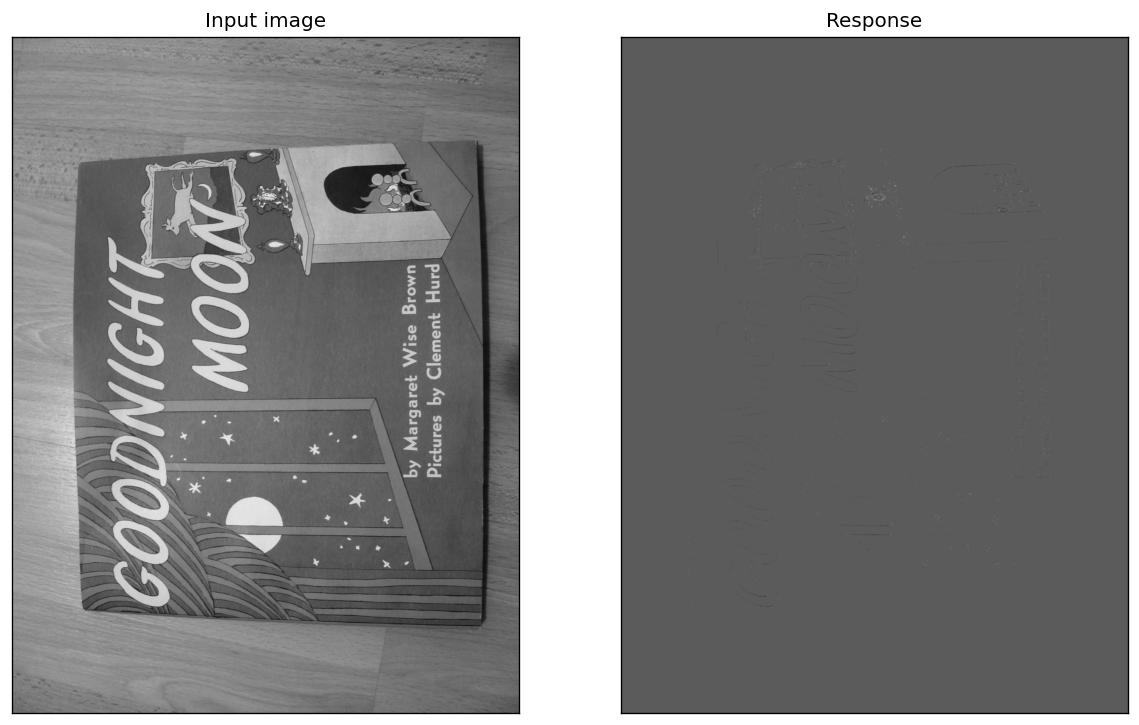

In [14]:
# choose either Shi-Tomasi or Harris response
# TODO 
response = response_harris_diy


plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(response, cmap=plt.cm.gray)
plt.title('Response')
plt.show()

### Plot the histogram of responses

(array([2709006., 1005595.,  608815.,  419405.,  309473.,  240865.,
         193294.,  159592.,  133594.,  114506.,   98994.,   86715.,
          76540.,   67632.,   61219.,   54776.,   49648.,   45336.,
          41959.,   38317.,   35065.,   32882.,   30650.,   28104.,
          26585.,   24684.,   23141.,   22078.,   20664.,   19472.]),
 array([0.00000000e+00, 3.33333333e-07, 6.66666667e-07, 1.00000000e-06,
        1.33333333e-06, 1.66666667e-06, 2.00000000e-06, 2.33333333e-06,
        2.66666667e-06, 3.00000000e-06, 3.33333333e-06, 3.66666667e-06,
        4.00000000e-06, 4.33333333e-06, 4.66666667e-06, 5.00000000e-06,
        5.33333333e-06, 5.66666667e-06, 6.00000000e-06, 6.33333333e-06,
        6.66666667e-06, 7.00000000e-06, 7.33333333e-06, 7.66666667e-06,
        8.00000000e-06, 8.33333333e-06, 8.66666667e-06, 9.00000000e-06,
        9.33333333e-06, 9.66666667e-06, 1.00000000e-05]),
 <BarContainer object of 30 artists>)

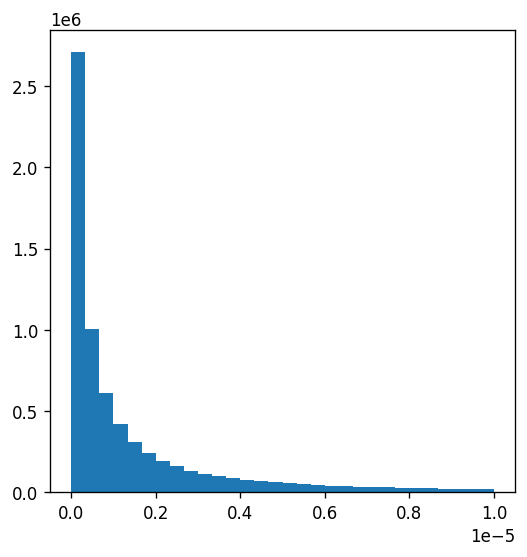

In [15]:
plt.figure(figsize=(5,5), dpi=DPI)
plt.hist(response.flatten()[response.flatten()>0], bins=30, range=(0,0.00001))

### Threshold the corners and visualise it

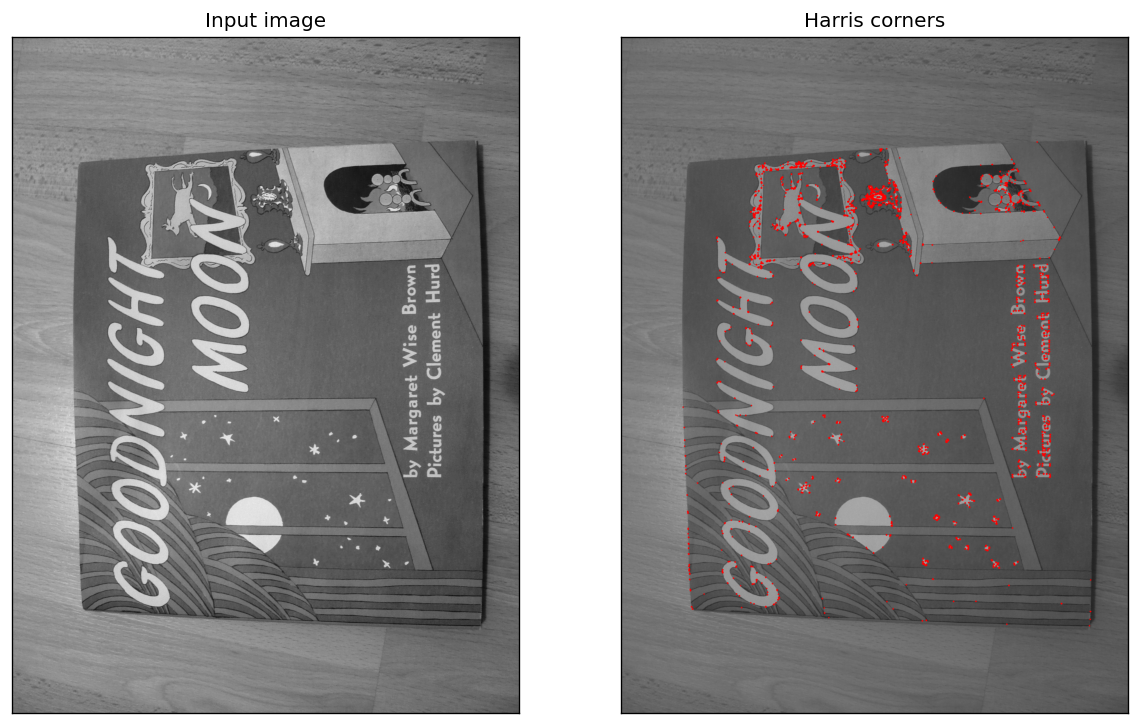

In [16]:
# TODO 
threshold = 0.003


corners =  cv2.cvtColor((input_img.copy() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
mask = response>threshold

x, y = np.where(mask)
for idx in range(len(x)):
    cv2.circle(corners, (y[idx],x[idx]), RADIUS, COLOR, THICKNESS)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow((input_img * 255).astype(np.uint8), cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(corners)
plt.title('Harris corners')
plt.show()

### Apply NMS

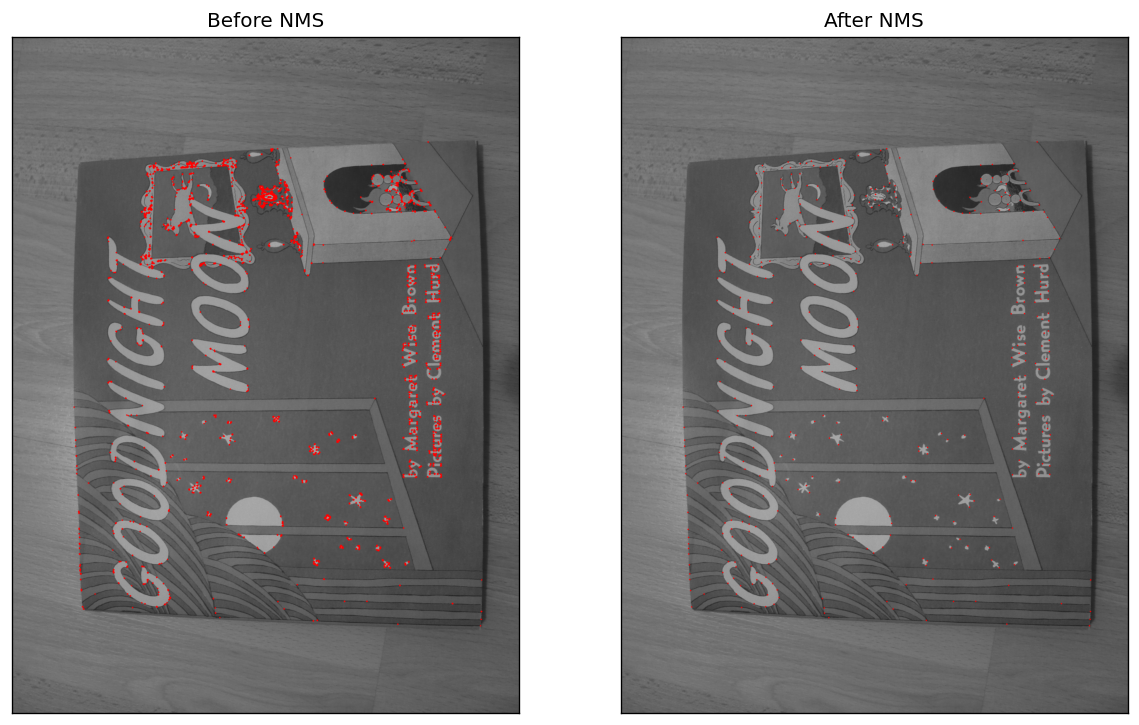

In [17]:
from scipy.ndimage import maximum_filter
# TODO

# Apply non-maximum suppression
max_filtered = maximum_filter(response, size=40, mode='constant')
mask = (response == max_filtered) & (response > threshold)


corners_filter =  cv2.cvtColor((input_img.copy() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
x, y = np.where(mask)
for idx in range(len(x)):
    cv2.circle(corners_filter, (y[idx],x[idx]), RADIUS, COLOR, THICKNESS)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(corners)
plt.title('Before NMS')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(corners_filter)
plt.title('After NMS')
plt.show()